In [27]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
import os
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("dark") # Theme for plots as Dark
sns.set_palette("viridis")
# sns.color_palette("flare")
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
import optuna
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from catboost import Pool, CatBoostClassifier, cv
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter
from sklearn.cluster import KMeans

In [28]:
train_data = pd.read_csv("train.csv",index_col="id")
test_data = pd.read_csv("test.csv",index_col="id")
orig_data = pd.read_csv("original.csv",index_col = "RowNumber")
orig_data.dropna(inplace=True)

# train_data.drop(["Surname"],inplace=True,axis=1)
# test_data.drop(["Surname"],inplace=True,axis=1)
# orig_data.drop(["Surname"],inplace=True,axis=1)

train_data = pd.concat([train_data,orig_data])
train_data.reset_index(drop=True,inplace=True)

In [29]:
train_data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [30]:
test_data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
id,,,,,,,,,,,,
165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


### Data Processing


In [31]:

label_enc = LabelEncoder()

train_data["Gender"] = label_enc.fit_transform(train_data[["Gender"]])
test_data["Gender"] = label_enc.transform(test_data[["Gender"]])
train_data["Geography"] = label_enc.fit_transform(train_data[["Geography"]])
test_data["Geography"] = label_enc.transform(test_data[["Geography"]])
train_data["Surname"] = label_enc.fit_transform(train_data[["Surname"]])
test_data["Surname"] = label_enc.transform(test_data[["Surname"]])

train_data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,2023,668,0,1,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,2024,627,0,1,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,1236,678,0,1,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,1362,581,0,1,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,491,716,2,1,33.0,5,0.00,2,1.0,1.0,15068.83,0


### Exploratory Data Analysis & Visualization 


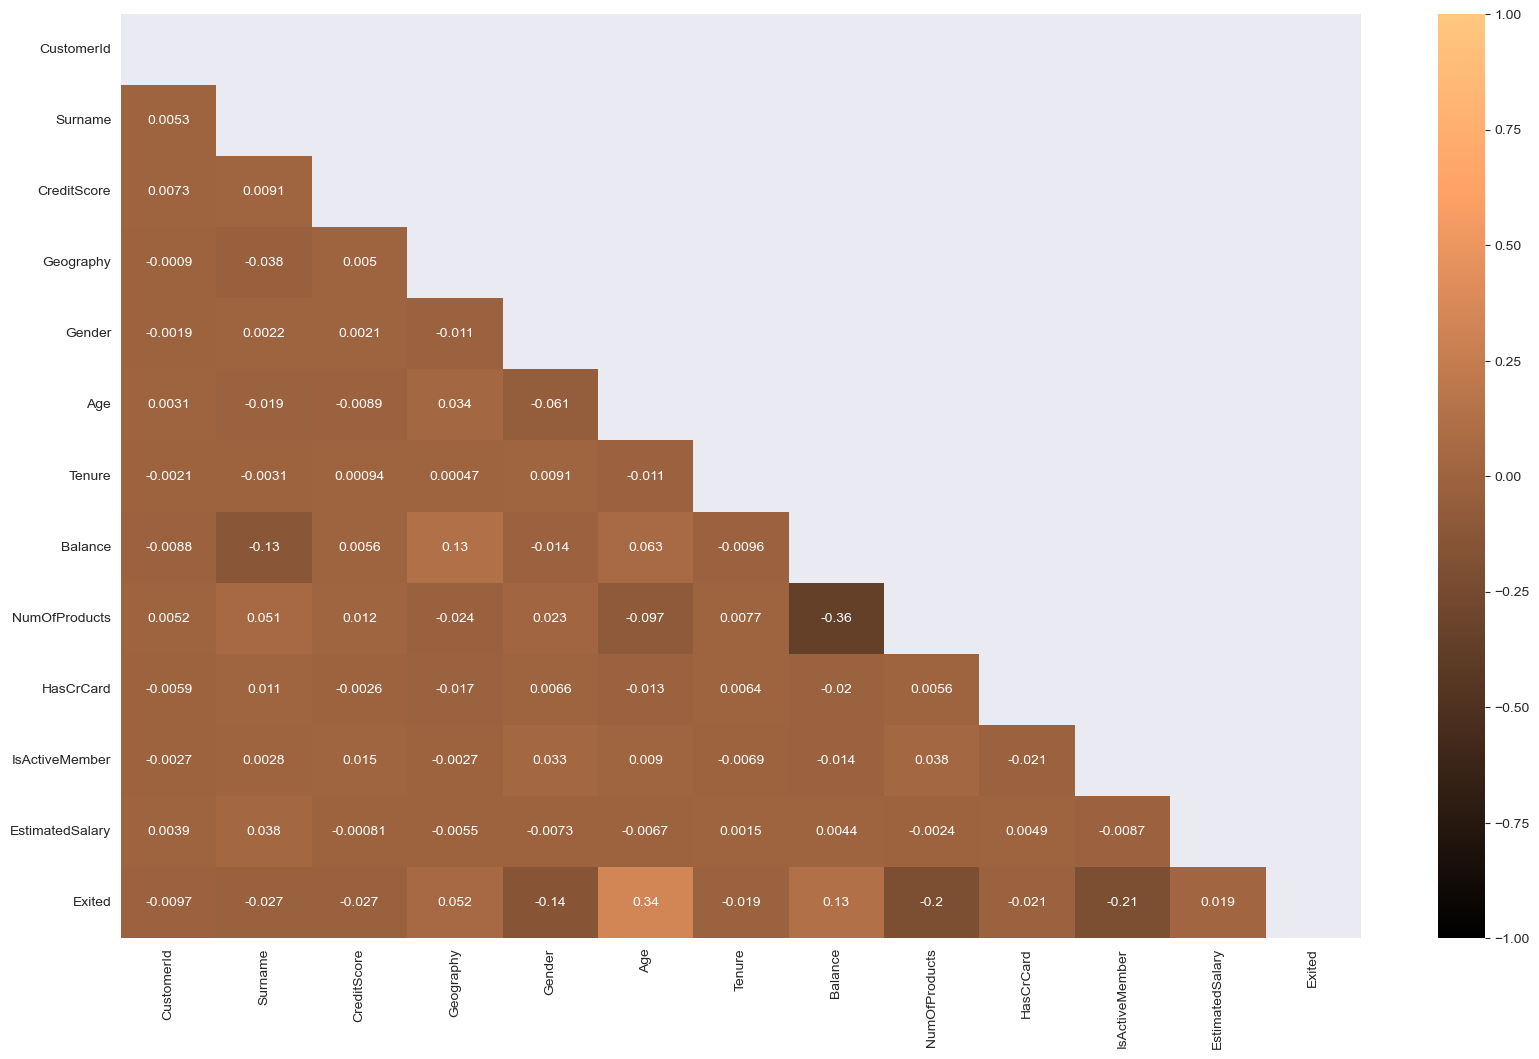

In [32]:
mask = np.triu(np.ones_like(train_data.corr()))
plt.figure(figsize=(20,12))
sns.heatmap(train_data.corr(), cmap="copper", annot=True, mask=mask,vmin=-1,vmax=1);

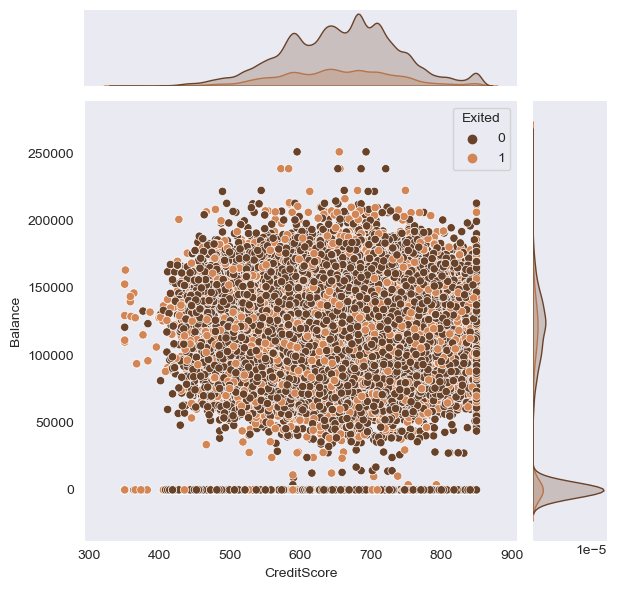

In [33]:
sns.jointplot(data=train_data, x="CreditScore", y="Balance", hue = "Exited", palette = "copper");

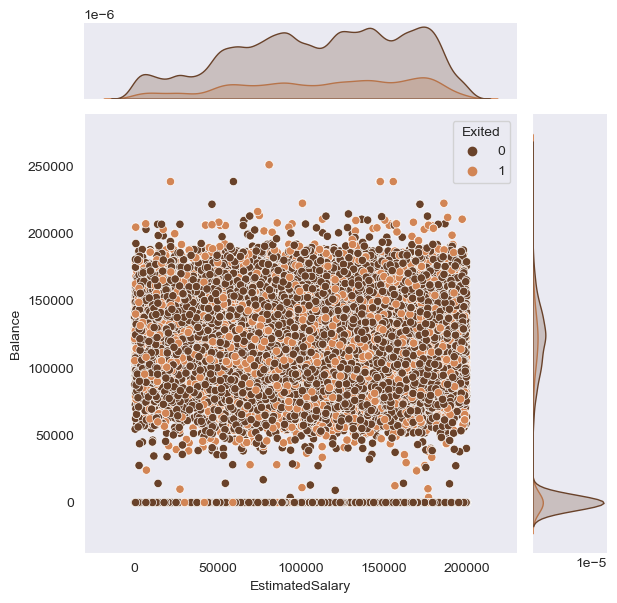

In [34]:
sns.jointplot(data=train_data, x="EstimatedSalary", y="Balance", hue = "Exited", palette = "copper");

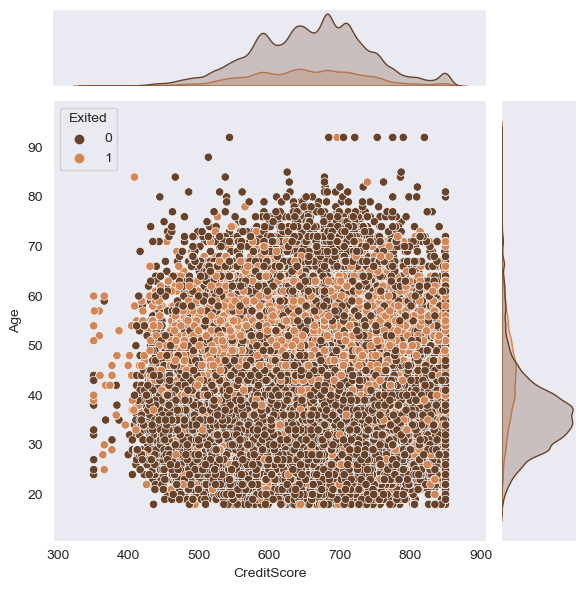

In [35]:
sns.jointplot(data=train_data, x="CreditScore", y="Age", hue = "Exited", palette = "copper");

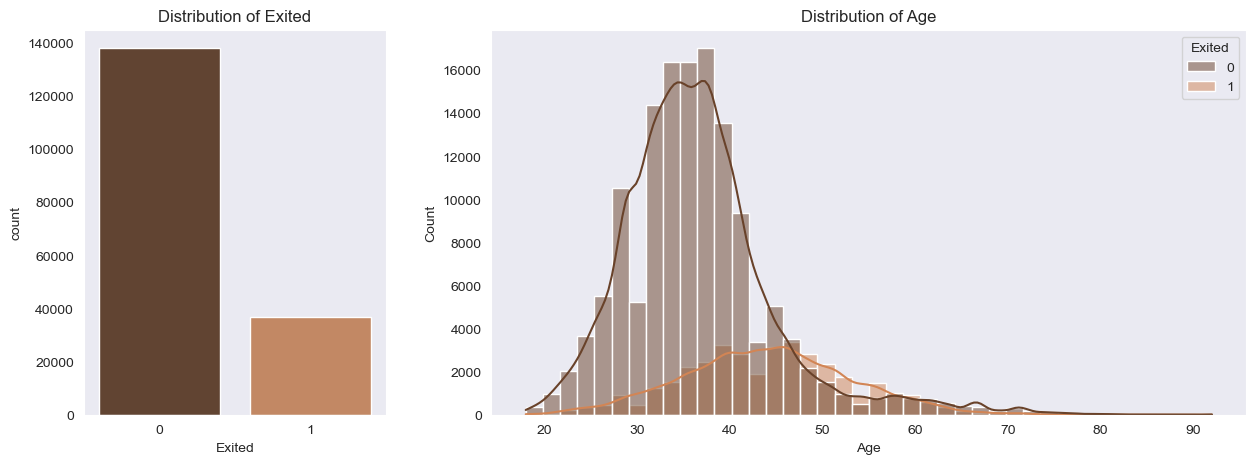

In [36]:
fig,axes = plt.subplots(1,2,figsize=(15,5),gridspec_kw={'width_ratios': [1, 2.5]})

plt.subplot(1,2,1)
sns.countplot(data=train_data,x="Exited", palette = "copper");
plt.title("Distribution of Exited")

plt.subplot(1,2,2)
sns.histplot(data=train_data,x="Age",hue="Exited", bins=40, kde=True, palette = "copper");
plt.title("Distribution of Age")

fig.show();

### Clustering

In [37]:
N_CLUSTERS = 20
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0, n_init="auto")

clusters_train = kmeans.fit_predict(train_data.drop(["Exited"],axis=1))
clusters_test = kmeans.predict(test_data)

train_data["cluster"] = clusters_train
test_data["cluster"] = clusters_test

In [38]:
clusts = list(dict(sorted(Counter(clusters_test).items(), key=lambda item: item[0])).values())
clusts.extend(list(dict(sorted(Counter(clusters_train).items(), key=lambda item: item[0])).values()))

clusters = pd.DataFrame()
clusters["clusters_type"] = ["test"]*N_CLUSTERS + ["train"]*N_CLUSTERS
clusters["Cluster Label"] = list(range(0,N_CLUSTERS))*2
clusters["No of Items"] = clusts

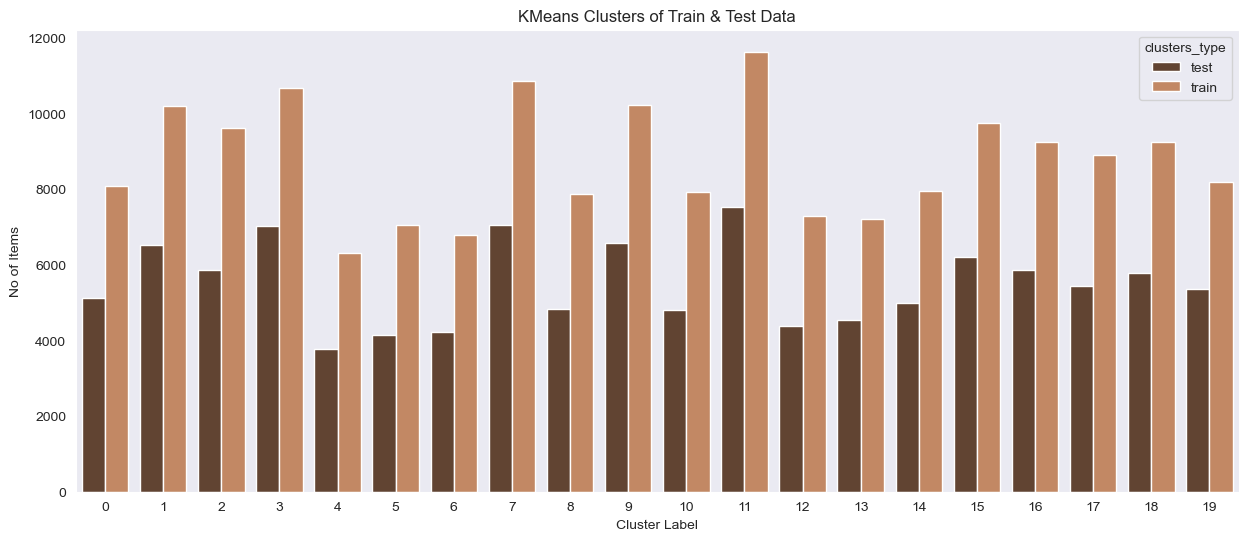

In [39]:
plt.figure(figsize=(15,6))
sns.barplot(clusters,x="Cluster Label",y="No of Items",hue="clusters_type",palette = "copper")
plt.title("KMeans Clusters of Train & Test Data");

In [40]:
clusters["No of Exited"] = 0
clusters["No of Exited"][clusters["clusters_type"]=="train"] = list(dict(sorted(Counter(train_data[train_data["Exited"]==1].cluster).items(), key=lambda item: item[0])).values())
clusters["Ratio of Exited"] = clusters["No of Exited"]/clusters["No of Items"]

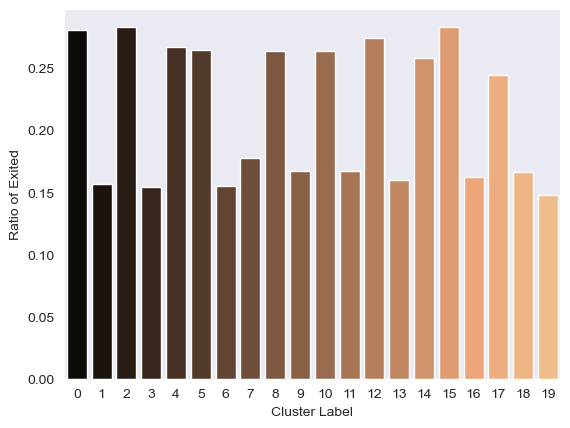

In [41]:
sns.barplot(data = clusters.query("clusters_type == 'train'"),y="Ratio of Exited", x ="Cluster Label",palette="copper");

### Training Models


In [42]:
seed = np.random.seed(6)

X = train_data.drop("Exited",axis=1)
y = train_data.Exited

X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.3)
print(len(X_train),len(X_val))

122522 52510


#### LGBM Classifier


In [53]:
def objective(trial):
    booster = trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart'])
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'verbosity': 0,
        'booster': booster,
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'eta': trial.suggest_loguniform('eta', 1e-8, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.5, 1, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.5, 1, 0.1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        # Adjust these parameters for CPU environment
        'tree_method': 'hist',  # Changed to 'hist' for CPU
        'predictor': 'cpu_predictor',  # Changed to 'cpu_predictor'
        'sampling_method': 'uniform'  # Set to 'uniform' for CPU compatibility
    }

    model = XGBClassifier(**param)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=False)
    preds = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, preds)
    return auc



study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best params:', study.best_params)


[I 2024-01-04 17:03:23,138] A new study created in memory with name: no-name-c3da6725-cfe0-4163-897b-b2c21b1d37f5
[W 2024-01-04 17:03:23,240] Trial 0 failed with parameters: {'booster': 'gblinear', 'lambda': 6.874192915353655e-05, 'alpha': 2.477613775162577e-07, 'max_depth': 6, 'eta': 0.09896982671674782, 'gamma': 0.03231531179758479, 'grow_policy': 'lossguide', 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 98} because of the following error: XGBoostError('[17:03:23] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/data/iterative_dmatrix.h:90: Not implemented.\nStack trace:\n  [bt] (0) 1   libxgboost.dylib                    0x000000016d5f5785 dmlc::LogMessageFatal::~LogMessageFatal() + 117\n  [bt] (1) 2   libxgboost.dylib                    0x000000016d6b3603 xgboost::data::IterativeDMatrix::GetRowBatches() + 83\n  [bt] (2) 3   libxgboost.dylib                    0x000000016d6ea529 xgboost::gbm::GBLinear::PredictBa

XGBoostError: [17:03:23] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/data/iterative_dmatrix.h:90: Not implemented.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000016d5f5785 dmlc::LogMessageFatal::~LogMessageFatal() + 117
  [bt] (1) 2   libxgboost.dylib                    0x000000016d6b3603 xgboost::data::IterativeDMatrix::GetRowBatches() + 83
  [bt] (2) 3   libxgboost.dylib                    0x000000016d6ea529 xgboost::gbm::GBLinear::PredictBatchInternal(xgboost::DMatrix*, std::__1::vector<float, std::__1::allocator<float> >*) + 473
  [bt] (3) 4   libxgboost.dylib                    0x000000016d6e7aaa xgboost::gbm::GBLinear::PredictBatch(xgboost::DMatrix*, xgboost::PredictionCacheEntry*, bool, unsigned int, unsigned int) + 122
  [bt] (4) 5   libxgboost.dylib                    0x000000016d72662b xgboost::LearnerImpl::PredictRaw(xgboost::DMatrix*, xgboost::PredictionCacheEntry*, bool, unsigned int, unsigned int) const + 91
  [bt] (5) 6   libxgboost.dylib                    0x000000016d7140c8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 440
  [bt] (6) 7   libxgboost.dylib                    0x000000016d610c8f XGBoosterUpdateOneIter + 143
  [bt] (7) 8   libffi.8.dylib                      0x000000010d2e6a22 ffi_call_unix64 + 82
  [bt] (8) 9   ???                                 0x0000000309de64c0 0x0 + 13050471616



In [48]:


# Define your hyperparameters in the lgb_params dictionary
lgb_params = {
    'lambda_l1': 2.890316333856256,
    'lambda_l2': 2.8468123294901346, 
    'num_leaves': 69,
    'feature_fraction': 0.7157182230266226,
    'bagging_fraction': 0.8004789385802639,
    'bagging_freq': 3,
    'min_child_samples': 54
}

# Specify the default parameters that you want to keep
default_params = {
    'boosting_type': 'gbdt',  # Default boosting type
    'objective': 'binary',   # Default objective for binary classification
    'metric': 'binary_logloss',  # Default metric for binary classification
    'random_state': seed,    # Keep your random_state
    'device': 'cpu',         # Keep your device
}

# Merge the default parameters and lgb_params
lgb_params = {**default_params, **lgb_params}

# Create the LGBMClassifier with the modified lgb_params
lgbmmodel = LGBMClassifier(**lgb_params)

# Fit the model to the training data
lgbmmodel.fit(X_train, y_train)

# Calculate the cross-validated ROC AUC score
cv_score = cross_val_score(lgbmmodel, X, y, cv=4, scoring='roc_auc').mean()
print("CV score of LGBM is ", cv_score)

# Predict on the validation data and calculate ROC AUC score
y_val_pred = lgbmmodel.predict(X_val)
roc_auc_val = roc_auc_score(y_val_pred, y_val)
print("ROC AUC over Val Data:", roc_auc_val)


[LightGBM] [Warning] lambda_l1 is set=2.890316333856256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.890316333856256
[LightGBM] [Warning] feature_fraction is set=0.7157182230266226, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7157182230266226
[LightGBM] [Warning] bagging_fraction is set=0.8004789385802639, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8004789385802639
[LightGBM] [Warning] lambda_l2 is set=2.8468123294901346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8468123294901346
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=2.890316333856256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.890316333856256
[LightGBM] [Warning] feature_fraction is set=0.7157182230266226, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7157182230266226
[LightGBM] [Warning] bagging_fraction is 

#### XGB Classifier


In [20]:
xgbmodel = XGBClassifier(random_state=seed)
xgbmodel.fit(X_train,y_train)
print("CV score of XGB is ",cross_val_score(xgbmodel,X,y,cv=4, scoring = 'roc_auc').mean())
print("ROC AUC over Val Data:",roc_auc_score(xgbmodel.predict(X_val),y_val))

CV score of XGB is  0.8891550843491038
ROC AUC over Val Data: 0.8137072933674913


### Out-of-Fold Predictions LGBM + CatBoost + XGB


In [21]:
submission = pd.DataFrame()
submission["id"] = test_data.index
submission["Exited"] = 0

In [22]:
SPLITS = 5
REPEATS = 1
lgbm_auc_score = []
cat_auc_score = []
xgb_auc_score = []

In [25]:
for i,(tr,val) in enumerate(RepeatedStratifiedKFold(n_splits=SPLITS, n_repeats=REPEATS,random_state=seed).split(X,y)):
    
    print("-"*30,f"FOLD {i+1}/{SPLITS*REPEATS}","-"*30)
    X_train, X_test, y_train, y_test = X.iloc[tr,:],X.iloc[val,:],y.iloc[tr],y.iloc[val]
    
    print("\n->","LGBM:")
    lgbmmodel = LGBMClassifier(n_estimators= 5000,random_state=seed,device="cpu")
    lgbmmodel.fit(X_train,y_train, eval_set=[(X_test,y_test)], eval_names=["valid"],eval_metric=['auc'], early_stopping_rounds=1000,verbose = 1000)
    auc = roc_auc_score(y_test, lgbmmodel.predict_proba(X_test)[:,1])
    lgbm_auc_score.append(auc)
    print(f"\nFold {i+1} ROC_AUC of LGBM =", auc,"\n")
    submission["Exited"] += lgbmmodel.predict_proba(test_data)[:,1]
    
    print("\n->","CAT:")
    train_dataset = Pool(data=X.iloc[tr,:],label=y.iloc[tr])
    eval_dataset = Pool(data=X.iloc[val,:],label=y.iloc[val])
    
    catmodel = CatBoostClassifier(iterations=5000,verbose=1000, od_type="Iter",eval_metric="AUC", random_seed=seed,early_stopping_rounds=500)
    catmodel.fit(train_dataset, use_best_model=True, eval_set=eval_dataset)
    auc = roc_auc_score(y.iloc[val], catmodel.predict_proba(X.iloc[val,:])[:,1])
    cat_auc_score.append(auc)
    submission["Exited"] += catmodel.predict_proba(test_data)[:,1]
    
    print("\n->","XGB:")
    xgbmodel = XGBClassifier(n_estimators= 5000,random_state=seed, eval_metric="auc",early_stopping_rounds = 1000)
    xgbmodel.fit(X_train,y_train, eval_set=[(X_test,y_test)],verbose = 1000,callbacks=[EarlyStopping(rounds = 1000,save_best=True)])
    auc = roc_auc_score(y_test, xgbmodel.predict_proba(X_test)[:,1])
    xgb_auc_score.append(auc)
    print(f"\nFold {i+1} ROC_AUC of XGB =", auc)
    submission["Exited"] += xgbmodel.predict_proba(test_data)[:,1]
    
print("\n\n","-"*50,sep="")
print("CV score of LGBM is ",np.array(lgbm_auc_score).mean())
print("CV score of CAT is ",np.array(cat_auc_score).mean())
print("CV score of XGB is ",np.array(xgb_auc_score).mean())

------------------------------ FOLD 1/5 ------------------------------

-> LGBM:
[1000]	valid's auc: 0.887224	valid's binary_logloss: 0.324591

Fold 1 ROC_AUC of LGBM = 0.8900028574916543 


-> CAT:
Learning rate set to 0.05333
0:	test: 0.8574537	best: 0.8574537 (0)	total: 75.3ms	remaining: 6m 16s
1000:	test: 0.8908678	best: 0.8909048 (927)	total: 12.2s	remaining: 48.5s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8909048142
bestIteration = 927

Shrink model to first 928 iterations.

-> XGB:
[0]	validation_0-auc:0.87154
[1000]	validation_0-auc:0.87455
[1077]	validation_0-auc:0.87366

Fold 1 ROC_AUC of XGB = 0.8900105168233903
------------------------------ FOLD 2/5 ------------------------------

-> LGBM:
[1000]	valid's auc: 0.88341	valid's binary_logloss: 0.327086

Fold 2 ROC_AUC of LGBM = 0.8861363499196198 


-> CAT:
Learning rate set to 0.05333
0:	test: 0.8545138	best: 0.8545138 (0)	total: 15.5ms	remaining: 1m 17s
1000:	test: 0.8865945	best: 0.8866524 (971)	

### Create submission


In [26]:
submission["Exited"] = submission["Exited"]/(SPLITS*REPEATS*3)

submission.to_csv("submission.csv",header=True,index=False)
submission

,id,Exited
0,165034,0.027133
1,165035,0.855947
2,165036,0.023685
3,165037,0.224595
4,165038,0.371246
...,...,...
110018,275052,0.034166
110019,275053,0.144460
110020,275054,0.018303
110021,275055,0.155698
